<a href="https://colab.research.google.com/github/eviediaz/GAN_Experiment/blob/main/Proyecto_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio matplotlib numpy tqdm pytorch-fid torchmetrics torch-fidelity torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 33.8 MB/s eta 0:00:00


In [ ]:
# Torch y utilidades
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid, save_image
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Numpy y visualización
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

# Barra de progreso
from tqdm import tqdm

In [ ]:
# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


#Datos

In [ ]:
# Ruta donde se almacenarán los datos
data_root = "data"

# Carga train/test sin transformaciones
train_data = datasets.FashionMNIST(root=data_root, train=True, download=True)
test_data  = datasets.FashionMNIST(root=data_root, train=False, download=True)

print(f"Imágenes de entrenamiento: {len(train_data)}")
print(f"Imágenes de prueba: {len(test_data)}")

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.15MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.7MB/s]

Imágenes de entrenamiento: 60000
Imágenes de prueba: 10000


#Preprocesamiento

In [ ]:
# Transformaciones: escala a [-1, 1] para usar Tanh en el generador
transform = transforms.Compose([
    transforms.Resize(32),              # Escalar a 32x32 para mejor estabilidad (opcional)
    transforms.ToTensor(),              # Convertir a tensor [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalizar a [-1,1]
])

# Aplicar al dataset de entrenamiento
dataset = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True) #Datos en lotes de 128

print(f"Total imágenes después del preprocesamiento: {len(dataset)}")

Total imágenes después del preprocesamiento: 60000


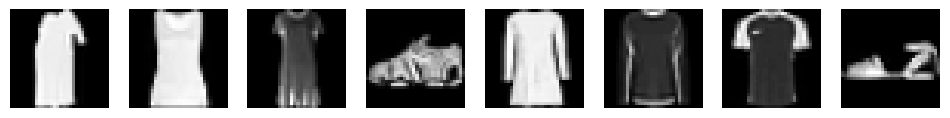

In [ ]:
# Obtener un batch
images, labels = next(iter(dataloader))

# Denormalizar para visualización (volver a [0,1])
def denormalize(img):
    return img * 0.5 + 0.5

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(denormalize(images[i]).squeeze().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

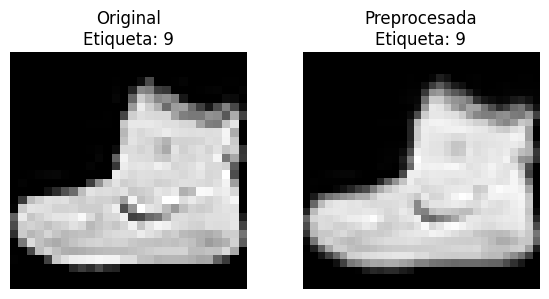

In [ ]:
index = 0

# Imagen original (sin transformaciones)
original_img, label_orig = train_data[index]

# Imagen transformada (con Resize, ToTensor y Normalize)
transformed_img, label_trans = dataset[index]

# Denormalizar para visualizar correctamente
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

# Convertir el tensor transformado a imagen numpy
img_trans_np = denormalize(transformed_img).squeeze().numpy()

# Mostrar ambas imágenes
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(original_img, cmap="gray")
axes[0].set_title(f"Original\nEtiqueta: {label_orig}")
axes[0].axis("off")

axes[1].imshow(img_trans_np, cmap="gray")
axes[1].set_title(f"Preprocesada\nEtiqueta: {label_trans}")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#Entrenamiento

In [ ]:
def save_grid_images(gen, fixed_noise, device, epoch, stage, model_name, out_dir="results"):
    os.makedirs(out_dir, exist_ok=True)
    gen.eval() #Modo evaluación
    with torch.no_grad():
        fake = gen(fixed_noise.to(device)).cpu() #Genera imágenes falsas con el Generador y un tensor de ruido (que es fijo en el entrenamiento)
    gen.train() #Vuelve a ponerlo en modo entrenamiento

    # Mostrar 8x8
    grid = torchvision.utils.make_grid(fake[:64], nrow=8, normalize=True) #Toam las 64 primeras imágenes y las normaliza para que se vean correctamente
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Modelo {model_name} - {stage}")
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.savefig(f"{out_dir}/model_{model_name}_{stage}.png") #Se genera una imagen de una etapa y época específica y se guarda
    plt.close()

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, features_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input Z latent vector
            nn.ConvTranspose2d(z_dim, features_g*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
# Función de entrenamiento
def train_dcgan(config, dataloader, device, save_dir="outputs"):

    os.makedirs(save_dir, exist_ok=True)

    z_dim = config["z_dim"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]

    # Modelos
    gen = Generator(z_dim=z_dim).to(device)
    disc = Discriminator().to(device)

    # Loss y optimizadores
    criterion = nn.BCELoss()
    optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

    # Listas para guardar pérdidas
    losses_G, losses_D = [], []

    for epoch in range(epochs):
        for real, _ in dataloader:
            real = real.to(device)
            batch_size = real.size(0)

            # Etiquetas
            label_real = torch.ones(batch_size, 1, device=device)
            label_fake = torch.zeros(batch_size, 1, device=device)

            # Entrenar Discriminador
            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake = gen(noise)

            disc_real = disc(real).view(-1, 1)
            lossD_real = criterion(disc_real, label_real)

            disc_fake = disc(fake.detach()).view(-1, 1)
            lossD_fake = criterion(disc_fake, label_fake)

            lossD = (lossD_real + lossD_fake) / 2
            optimizer_disc.zero_grad()
            lossD.backward()
            optimizer_disc.step()

            # Entrenar Generador
            output = disc(fake).view(-1, 1)
            lossG = criterion(output, label_real)  # queremos engañar al discriminador
            optimizer_gen.zero_grad()
            lossG.backward()
            optimizer_gen.step()

        # Guardar pérdidas
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())

        print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

        # Guardar imágenes inicio / mitad / final
        if epoch == 0:
            stage = "inicio"
        elif epoch == epochs // 2:
            stage = "mitad"
        elif epoch == epochs - 1:
            stage = "final"
        else:
            stage = None

        if stage is not None:
          save_grid_images(
              gen=gen,
              fixed_noise=fixed_noise,
              device=device,
              epoch=epoch+1,
              stage=stage,
              model_name=config.get("name", "X"),   # el nombre de la config (A, B o C)
              out_dir=save_dir
          )

    # Guardar modelos
    torch.save(gen.state_dict(), os.path.join(save_dir, f"generator_{config.get('name','X')}.pth"))
    torch.save(disc.state_dict(), os.path.join(save_dir, f"discriminator_{config.get('name','X')}.pth"))

    return gen, disc, fixed_noise, losses_G, losses_D

In [ ]:
def denorm(img):
    return (img + 1) / 2

In [ ]:
def save_comparison(gen, dataloader, fixed_noise, device, model_name, out_dir="results"):
    os.makedirs(out_dir, exist_ok=True)
    gen.eval()
    with torch.no_grad():
        fake = gen(fixed_noise.to(device)).cpu()

    fake_img = fake[0]
    fake_flat = fake_img.view(-1)

    min_dist, best_real = 1e9, None
    for real_batch, _ in dataloader:
        for real_img in real_batch:
            dist = F.mse_loss(fake_flat, real_img.view(-1)).item()
            if dist < min_dist:
                min_dist, best_real = dist, real_img

    # Mostrar lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(denorm(fake_img).permute(1, 2, 0).numpy())
    axes[0].set_title("Generado")
    axes[0].axis("off")

    axes[1].imshow(denorm(best_real).permute(1, 2, 0).numpy())
    axes[1].set_title("Real más parecida")
    axes[1].axis("off")

    plt.savefig(f"{out_dir}/model_{model_name}_comparacion.png")
    plt.close()

In [ ]:
configs = {
    "A": {"z_dim": 100, "batch_size": 128, "lr": 0.0002, "epochs": 30},
    "B": {"z_dim": 50,  "batch_size": 64,  "lr": 0.0002, "epochs": 30},
    "C": {"z_dim": 200, "batch_size": 128, "lr": 0.0002, "epochs": 30}
}

results = {}
os.makedirs("checkpoints", exist_ok=True)  # crea la carpeta si no existe

for name, cfg in configs.items():
    print(f"\nEntrenando configuración {name}...")
    cfg["name"] = name   # <- añadir nombre a la config
    gen, disc, fixed_noise, losses_G, losses_D = train_dcgan(cfg, dataloader, device, save_dir=f"outputs/{name}")

    results[name] = {
        "G": gen,
        "D": disc,
        "noise": fixed_noise,
        "losses_G": losses_G,
        "losses_D": losses_D,
    }

    save_comparison(gen, dataloader, fixed_noise, device, model_name=name, out_dir="results")

    torch.save({
        "G": gen.state_dict(),
        "D": disc.state_dict(),
        "noise": fixed_noise,
        "losses_G": losses_G,
        "losses_D": losses_D
    }, f"checkpoints/model_{name}.pth")


Entrenando configuración A...
Epoch [1/30]  Loss D: 0.3170, Loss G: 1.9111
Epoch [2/30]  Loss D: 0.1082, Loss G: 2.7765
Epoch [3/30]  Loss D: 0.0868, Loss G: 2.8091
Epoch [4/30]  Loss D: 0.0185, Loss G: 7.2517
Epoch [5/30]  Loss D: 0.3866, Loss G: 1.5383
Epoch [6/30]  Loss D: 0.0314, Loss G: 3.8716
Epoch [7/30]  Loss D: 0.0057, Loss G: 5.3957
Epoch [8/30]  Loss D: 0.0228, Loss G: 4.5930
Epoch [9/30]  Loss D: 0.6635, Loss G: 5.4675
Epoch [10/30]  Loss D: 0.0082, Loss G: 5.8062
Epoch [11/30]  Loss D: 0.0697, Loss G: 4.1865
Epoch [12/30]  Loss D: 0.0088, Loss G: 5.1870
Epoch [13/30]  Loss D: 0.0043, Loss G: 6.8052
Epoch [14/30]  Loss D: 0.0052, Loss G: 8.1556
Epoch [15/30]  Loss D: 0.0600, Loss G: 4.0136
Epoch [16/30]  Loss D: 0.0104, Loss G: 5.5577
Epoch [17/30]  Loss D: 0.0027, Loss G: 7.4181
Epoch [18/30]  Loss D: 0.2165, Loss G: 3.9268
Epoch [19/30]  Loss D: 0.0172, Loss G: 4.7276
Epoch [20/30]  Loss D: 0.0077, Loss G: 5.4534
Epoch [21/30]  Loss D: 0.0656, Loss G: 3.6748
Epoch [22/30

#Evaluación

In [ ]:
def generate_images(gen, z_dim, device, folder="results_eval", n_images=5000, batch_size=128):
    os.makedirs(folder, exist_ok=True)
    gen.eval()
    with torch.no_grad():
        for i in range(n_images // batch_size):
            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake = gen(noise).detach().cpu()
            for j in range(fake.size(0)):
                save_image(fake[j], f"{folder}/img_{i*batch_size+j}.png", normalize=True)

In [ ]:
def preprocess_for_metrics(batch):
    """
    Convierte tensores float [-1, 1] o [0, 1] en uint8 [0, 255]
    para métricas como FID / IS.
    """
    if batch.dtype != torch.uint8:
        # Si estaba en [-1, 1] → lo llevamos a [0, 1]
        if batch.min() < 0:
            batch = (batch + 1) / 2
        # Se escala a [0, 255] y convierte a uint8
        batch = (batch * 255).clamp(0, 255).byte()
    return batch

In [ ]:
def to_rgb(x):
    # x: [B, 1, H, W]
    return x.repeat(1, 3, 1, 1)  # [B, 3, H, W]

In [ ]:
# Evaluación por cada modelo
evals = {}
fid_scores = []
kid_scores = []
is_means = []
is_stds = []

for name, model_data in results.items():
    print(f"🔎 Evaluando modelo {name}...")

    gen = model_data["G"]
    disc = model_data["D"]
    fixed_noise = model_data["noise"]

    z_dim = configs[name]["z_dim"]
    batch_size = configs[name]["batch_size"]

    # Inicializar métricas
    fid = FrechetInceptionDistance(feature=64).to(device)
    kid = KernelInceptionDistance(subset_size=50).to(device)
    inception = InceptionScore().to(device)

    # Evaluar sobre un número limitado de batches
    num_batches_eval = 5  # <-- puedes ajustar este número
    for i, (real_batch, _) in enumerate(dataloader):
        if i >= num_batches_eval:
            break

        real_batch = real_batch.to(device)

        # Generar imágenes falsas
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_batch = gen(noise)

        # Preprocesar imágenes
        real_batch_proc = preprocess_for_metrics(real_batch)
        fake_batch_proc = preprocess_for_metrics(fake_batch)

        # Convertir a RGB
        real_batch_proc = to_rgb(real_batch_proc)
        fake_batch_proc = to_rgb(fake_batch_proc)

        # Actualizar métricas
        fid.update(real_batch_proc, real=True)
        fid.update(fake_batch_proc, real=False)

        kid.update(real_batch_proc, real=True)
        kid.update(fake_batch_proc, real=False)

        inception.update(fake_batch_proc)

    # Calcular puntajes
    fid_score = fid.compute().item()
    kid_score = kid.compute()[0].item()
    inception_mean, inception_std = inception.compute()

    fid_scores.append(fid_score)
    kid_scores.append(kid_score)
    is_means.append(inception_mean.item())
    is_stds.append(inception_std.item())

    evals[name] = {
        "FID": fid_score,
        "KID": kid_score,
        "IS_mean": inception_mean.item(),
        "IS_std": inception_std.item()
    }

# Mostrar resultados
for name, metrics in evals.items():
    print(f"\n📊 Resultados {name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

🔎 Evaluando modelo A...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 97.9MB/s]
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


🔎 Evaluando modelo B...
🔎 Evaluando modelo C...

📊 Resultados A:
  FID: 0.0276
  KID: 0.0394
  IS_mean: 3.4969
  IS_std: 0.3038

📊 Resultados B:
  FID: 0.0209
  KID: 0.0276
  IS_mean: 3.4715
  IS_std: 0.3631

📊 Resultados C:
  FID: 0.0139
  KID: 0.0304
  IS_mean: 3.5434
  IS_std: 0.2167


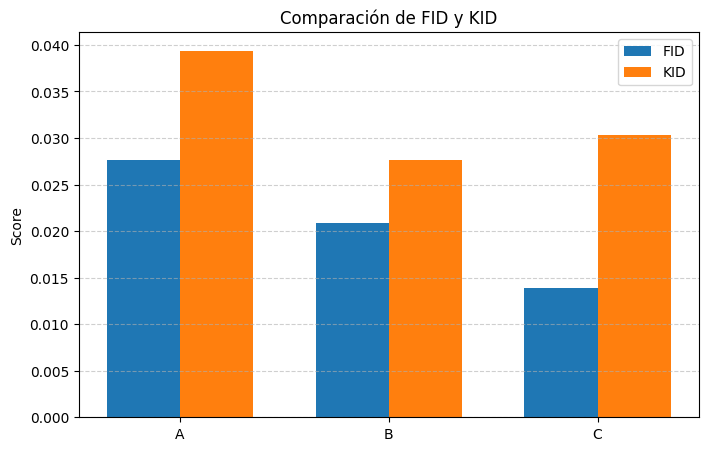

In [ ]:
# Datos
x = np.arange(len(configs))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, fid_scores, width, label="FID")
plt.bar(x + width/2, kid_scores, width, label="KID")
plt.xticks(x, configs)
plt.ylabel("Score")
plt.title("Comparación de FID y KID")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

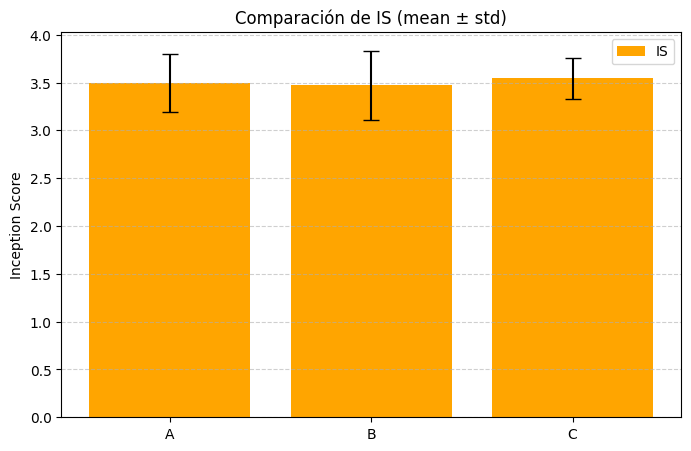

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(x, is_means, yerr=is_stds, capsize=6, color="orange", label="IS")
plt.ylabel("Inception Score")
plt.title("Comparación de IS (mean ± std)")
plt.xticks(x, configs)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

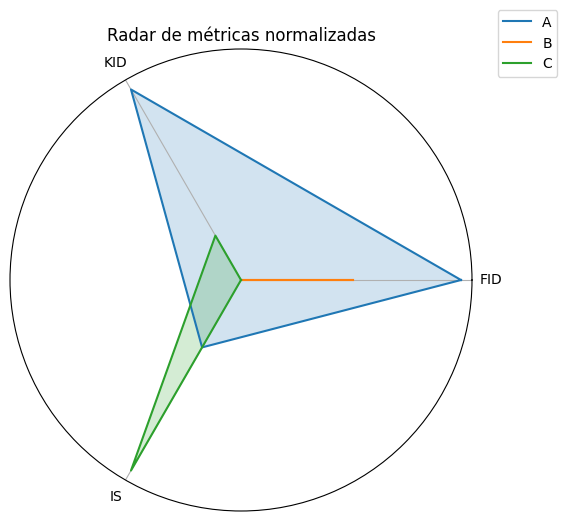

In [ ]:
def plot_radar(configs, fid, kid, is_mean):
    metrics = ["FID", "KID", "IS"]
    values = np.array([fid, kid, is_mean])
    values = (values - values.min(axis=1, keepdims=True)) / (values.max(axis=1, keepdims=True) - values.min(axis=1, keepdims=True) + 1e-9)

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # cerrar el círculo

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

    for i, config in enumerate(configs):
        vals = values[:,i].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, label=config)
        ax.fill(angles, vals, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticks([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.title("Radar de métricas normalizadas")
    plt.show()

plot_radar(configs, fid_scores, kid_scores, is_means)

In [ ]:
df_results = pd.DataFrame({
    "Config": x,
    "FID": fid_scores,
    "KID": kid_scores,
    "IS_mean": is_means,
    "IS_std": is_stds
})

print(df_results)

   Config       FID       KID   IS_mean    IS_std
0       0  0.027636  0.039390  3.496917  0.303776
1       1  0.020862  0.027615  3.471461  0.363097
2       2  0.013888  0.030357  3.543423  0.216749


In [ ]:
def smooth_curve(values, beta=0.9):
    smoothed = []
    avg = 0
    for v in values:
        avg = beta * avg + (1-beta) * v
        smoothed.append(avg)
    return smoothed

In [ ]:
def plot_losses(losses_G, losses_D, title="Loss Curves"):
    plt.figure(figsize=(8,4))
    plt.plot(losses_G, label="Generador")
    plt.plot(losses_D, label="Discriminador")
    plt.xlabel("Iteraciones")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_losses_smooth(losses_G, losses_D, title="Loss Curves"):
    plt.figure(figsize=(8,4))
    plt.plot(smooth_curve(losses_G), label="Generador", color="blue")
    plt.plot(smooth_curve(losses_D), label="Discriminador", color="red")
    plt.xlabel("Iteraciones")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

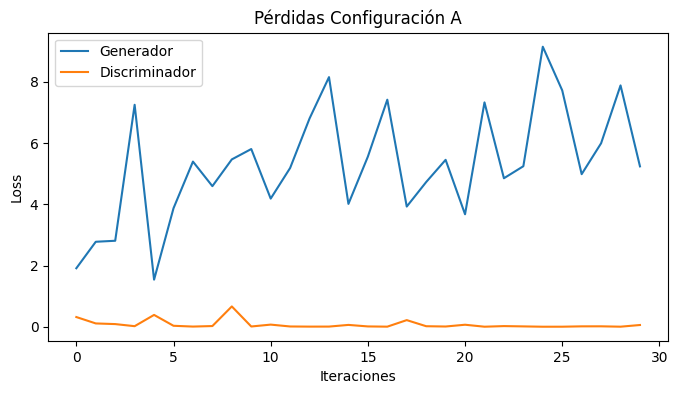

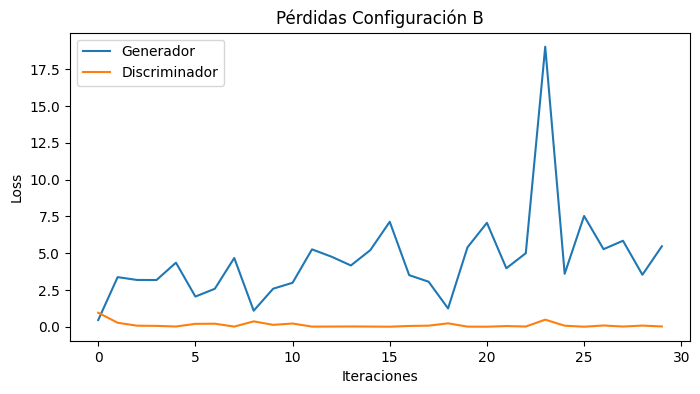

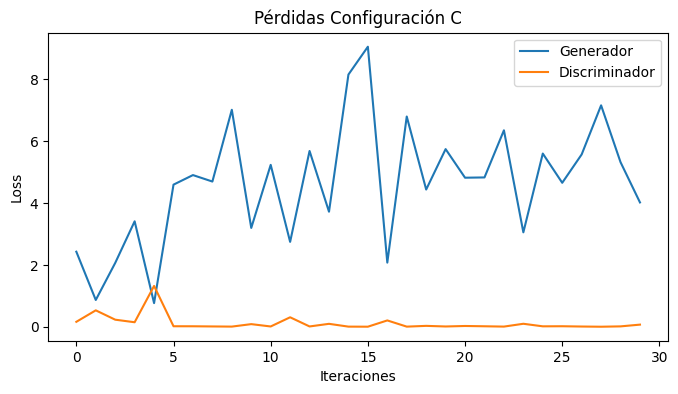

In [ ]:
for name, res in results.items():
    plot_losses(
        res["losses_G"],
        res["losses_D"],
        title=f"Pérdidas Configuración {name}"
    )

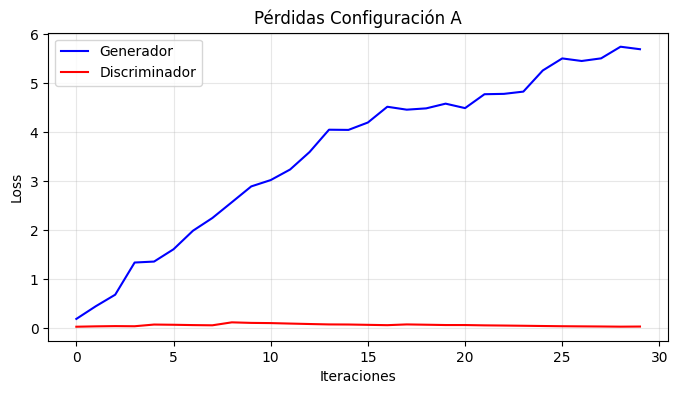

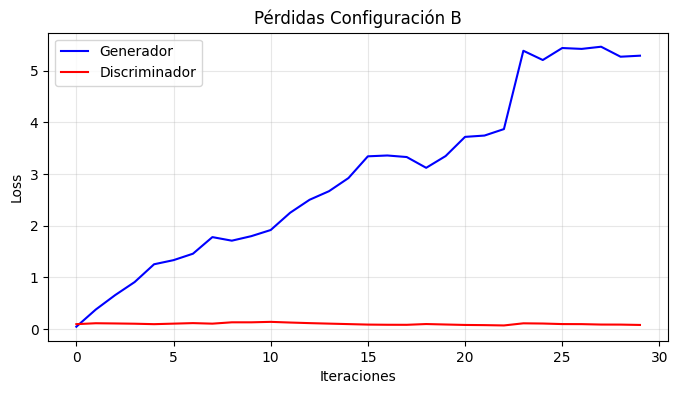

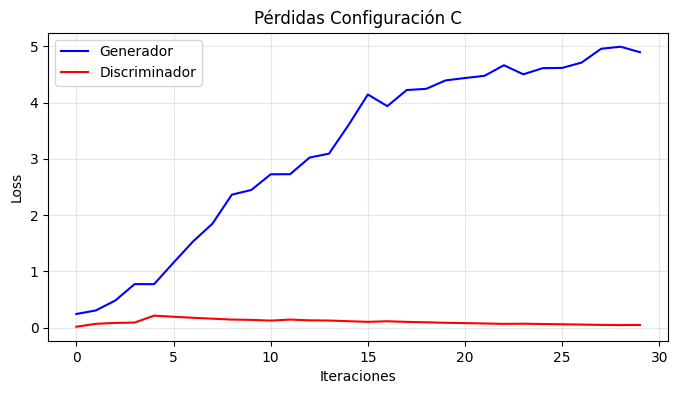

In [ ]:
for name, res in results.items():
    plot_losses_smooth(
        res["losses_G"],
        res["losses_D"],
        title=f"Pérdidas Configuración {name}"
    )

#Inferencia de ejemplo


Visualizando modelo A...



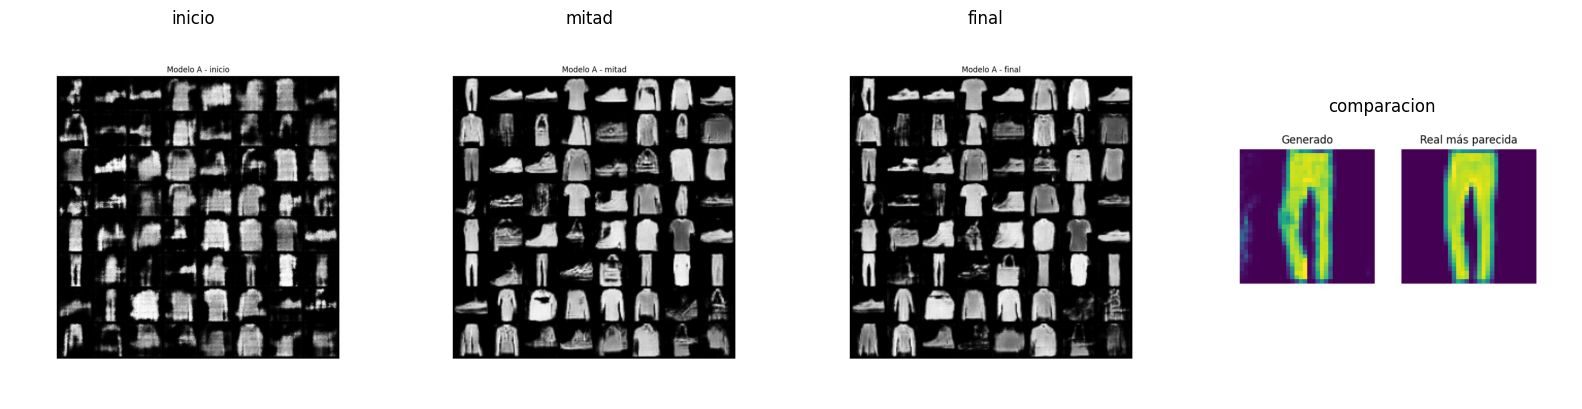


Visualizando modelo B...



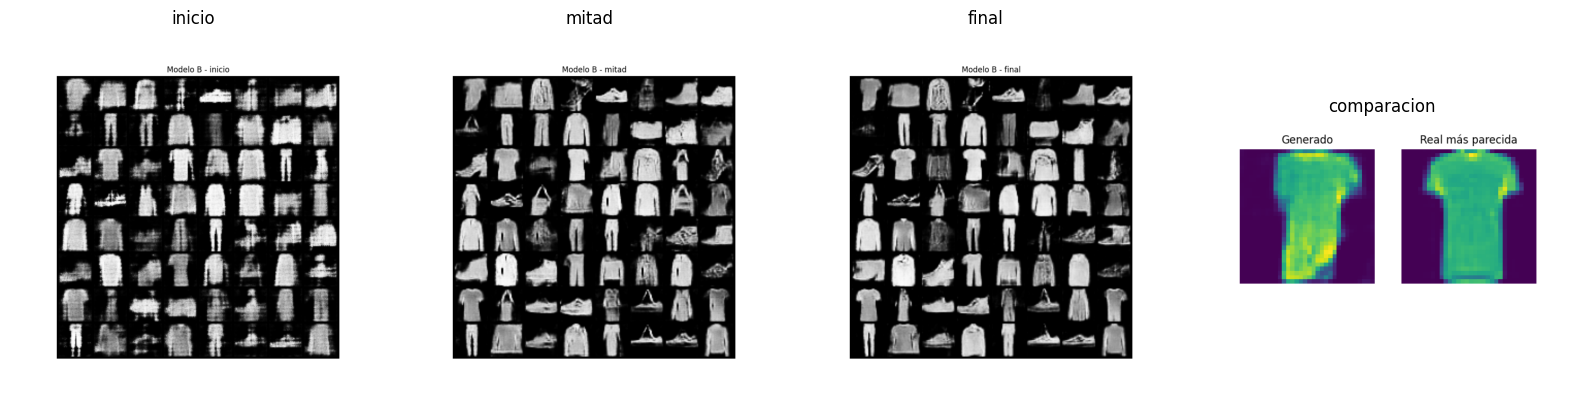


Visualizando modelo C...



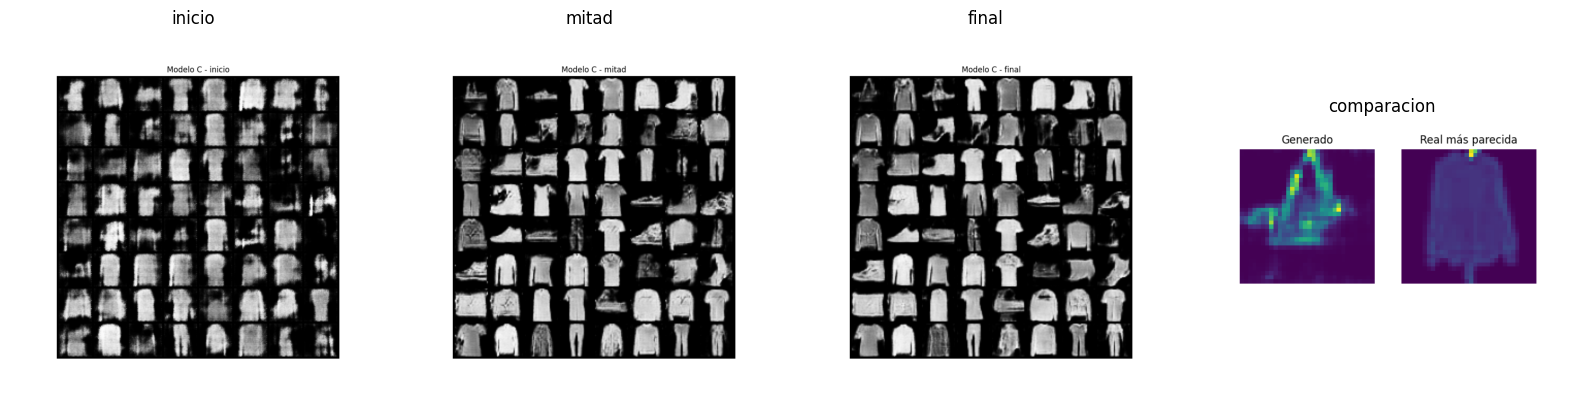

In [ ]:
stages = ["inicio", "mitad", "final"]

for name in configs:
    print(f"\nVisualizando modelo {name}...\n")

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, stage in enumerate(stages):
        path = f"outputs/{name}/model_{name}_{stage}.png"
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(stage)

    # Imagen de comparación final
    comparison_path = f"results/model_{name}_comparacion.png"
    img_comp = mpimg.imread(comparison_path)
    axes[3].imshow(img_comp)
    axes[3].axis('off')
    axes[3].set_title("4comparacion")

    plt.tight_layout()
    plt.show()